### Notebook - 2

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',95)
pd.set_option('display.max_rows',None)

In [ ]:
# Install mlxtend library to run the apriori algorithm
#pip install pandas mlxtend

In [2]:
# Reading in our most current dataset
main_df1 = pd.read_csv('./data/main_df1.csv.gz')

In [8]:
# Shape of the dataframe
main_df1.shape

(20095649, 10)

In [15]:
# Check five rows
main_df1.head()

,invoice/item_number,date,store_number,category,category_name,item_description,bottles_sold,sale_dollars,volume_sold_liters,store_name_y
0,INV-11049300044,2018-03-22,4958,1071100.0,Cocktails /RTD,Bacardi Party Drinks Zombie,3,31.41,5.25,Five Corners Liquor & Wine
1,INV-11058000109,2018-03-22,5162,1062100.0,Gold Rum,Bacardi Gold Rum Mini,1,8.31,0.50,Urbandale Liquor
2,INV-11064700013,2018-03-22,3806,1031100.0,American Vodkas,Hawkeye Vodka,6,64.56,10.50,Target Store T-1901 / Wdm
3,INV-11034800060,2018-03-21,2603,1022200.0,100% Agave Tequila,El Mayor Anejo Tequila,6,157.50,4.50,Hy-Vee Wine and Spirits / Bettendorf
4,INV-11095900025,2018-03-26,5350,1081200.0,Cream Liqueurs,Baileys Original Irish Cream,3,31.50,1.12,Casey's General Store # 3562/ Marion


In [16]:
# Checking the missingness
main_df1.isna().sum()

invoice/item_number        0
date                       0
store_number               0
category               16974
category_name          25040
item_description           0
bottles_sold               0
sale_dollars              10
volume_sold_liters         0
store_name_y               0
dtype: int64

In [3]:
# Reading in our most current dataset
main_df2 = pd.read_csv('./data/main_df2.csv.gz')

In [34]:
main_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20095649 entries, 0 to 20095648
Data columns (total 10 columns):
invoice/item_number    object
date                   object
store_number           int64
item_number            object
item_description       object
bottles_sold           int64
sale_dollars           float64
volume_sold_liters     float64
store_name2            object
category_name2         object
dtypes: float64(2), int64(2), object(6)
memory usage: 1.5+ GB


In [7]:
# Shape of the dataframe
main_df2.shape

(20095649, 10)

In [35]:
main_df2.head()

,invoice/item_number,date,store_number,item_number,item_description,bottles_sold,sale_dollars,volume_sold_liters,store_name2,category_name2
0,INV-11049300044,2018-03-22,4958,56843,Bacardi Party Drinks Zombie,3,31.41,5.25,Five Corners Liquor & Wine,cocktails
1,INV-11058000109,2018-03-22,5162,43031,Bacardi Gold Rum Mini,1,8.31,0.50,Urbandale Liquor,rum
2,INV-11064700013,2018-03-22,3806,36308,Hawkeye Vodka,6,64.56,10.50,Target Store T-1901 / Wdm,vodka
3,INV-11034800060,2018-03-21,2603,89178,El Mayor Anejo Tequila,6,157.50,4.50,Hy-Vee Wine and Spirits / Bettendorf,tequila
4,INV-11095900025,2018-03-26,5350,68034,Baileys Original Irish Cream,3,31.50,1.12,Casey's General Store # 3562/ Marion,cordials liqueurs


In [4]:
main_df2['date']=pd.to_datetime(main_df2['date'])

In [8]:
# Checking the missingness
main_df2.isna().sum()

invoice/item_number     0
date                    0
store_number            0
item_number             0
item_description        0
bottles_sold            0
sale_dollars           10
volume_sold_liters      0
store_name2             0
category_name2          0
dtype: int64

In [ ]:
main_df2['store_name2'].tolist()

In [5]:
# Cleaning store_name2 so object is in all lower case letters 
main_df2['store_name2'] = main_df2['store_name2'].str.lower()

In [6]:
# Creating and cleaning the store names into a store_type column

def contains(string, match_list):
    for match in match_list:
        if match in string:
            return True
    return False

def store_cleaner(value):
    """
    To be applied to a dataframe column to clean
    alcohol categories so they are simpler.
    """
    import pandas as pd
    
    if contains(value, ['hy-vee', 'chopper', 'supermarket', 'supermarkets', 'pioneer','fareway','dahl\'s', 'brooklyn','hometown', 'freeman','fredericksbury','brothers','brother\'s']):
        return 'supermarket'
    elif contains(value, ['wal-mart','w-mart', 'target', 'sam\'s','costco']):
        return 'big box'
    elif contains(value, ['walgreens', 'cvs', 'hartig']):
        return 'drugstore'
    elif contains(value, ['casey\'s','yesway', 'station', 'stop', 'mart', 'go', 'quik', 'todd\'s', 'quick', 'mart', 'kwik',' express', 'flashmart', 'fuel', '7-eleven', 'bp', '4']):
        return 'convenience store'
    else:
        return 'retail store'  
    
main_df2['store_type'] = main_df2['store_name2'].apply(store_cleaner)

In [ ]:
# # This is our table with newly created store_type column and saving to csv so we don't have to re-load
# main_df2.to_csv('./data/main_df3.csv.gz',index=False,compression='gzip')

### Market Basket Analysis

In [39]:
# Count of different store types
main_df2.store_type.value_counts()

supermarket          8289391
retail store         6700292
convenience store    3233610
big box              1517205
drugstore             355151
Name: store_type, dtype: int64

In [7]:
# Change item_description to item_name
main_df2.rename(columns={'item_description' : 'item_name'},inplace=True)

In [62]:
len(main_df2.item_name.unique()) # 8860 distinct item names in the dataset

8860

In [47]:
main_df2.item_name.value_counts().head(50)

Black Velvet                                520565
Hawkeye Vodka                               457376
Five O'clock Vodka                          257290
Fireball Cinnamon Whiskey                   243555
Jim Beam                                    212672
Captain Morgan Spiced Rum                   211468
Admiral Nelson Spiced Rum                   201984
Titos Handmade Vodka                        190786
Seagrams 7 Crown Bl Whiskey                 180805
Jagermeister Liqueur                        176348
Jack Daniels Old #7 Black Lbl               175576
Five Star                                   163000
Absolut Swedish Vodka 80 Prf                156947
Bacardi Superior Rum                        153722
Malibu Coconut Rum                          152316
Mccormick Vodka Pet                         152222
Paramount White Rum                         151806
Southern Comfort                            144392
Hennessy VS                                 140552
Crown Royal                    

In [8]:
# Filter for top 50 item names that accounted for higher volume sales
top_50 = main_df2.groupby(['item_name']).agg({'volume_sold_liters': 'sum'}).sort_values(by = 'volume_sold_liters', ascending= False)\
        .reset_index()[0:50]['item_name'].tolist()

In [48]:
top_50[0:10]

['Black Velvet',
 'Hawkeye Vodka',
 'Captain Morgan Spiced Rum',
 'Titos Handmade Vodka',
 'Fireball Cinnamon Whiskey',
 'Barton Vodka',
 "Five O'clock Vodka",
 'Phillips Vodka',
 'Jack Daniels Old #7 Black Lbl',
 'Admiral Nelson Spiced Rum']

In [9]:
# Create dataframe using top_50 item name list for MBA 
df_top_50 = main_df2.loc[main_df2['item_name'].isin(top_50)]
df_top_50.head()

,invoice/item_number,date,store_number,item_number,item_name,bottles_sold,sale_dollars,volume_sold_liters,store_name2,category_name2,store_type
2,INV-11064700013,2018-03-22,3806,36308,Hawkeye Vodka,6,64.56,10.50,target store t-1901 / wdm,vodka,big box
5,INV-11065200015,2018-03-22,2521,86884,Southern Comfort,24,172.08,9.00,hy-vee food and drug / grand / wdm,whiskey,supermarket
7,INV-11070000025,2018-03-23,2550,37938,Skol Vodka,3,32.01,5.25,hy-vee food store / osceola,vodka,supermarket
8,INV-11052600030,2018-03-22,2652,36904,Mccormick Vodka Pet,24,64.80,9.00,hy-vee drugstore / mason city,vodka,supermarket
10,INV-11040800041,2018-03-21,4157,37996,Smirnoff 80prf,6,74.28,4.50,fareway stores #993 / north liberty,vodka,supermarket


In [64]:
main_df2.shape

(20095649, 11)

In [63]:
# shape of the df_top_50
df_top_50.shape

(7121399, 11)

In [11]:
# Filter on store_type = supermarket and create a dataframe
df_supermarket = df_top_50.loc[df_top_50['store_type']=='supermarket']
# df1=  df_supermarket.groupby([pd.Grouper(key='date', freq='M'),'store_number','item_name']).\
#         size().reset_index(name='count')

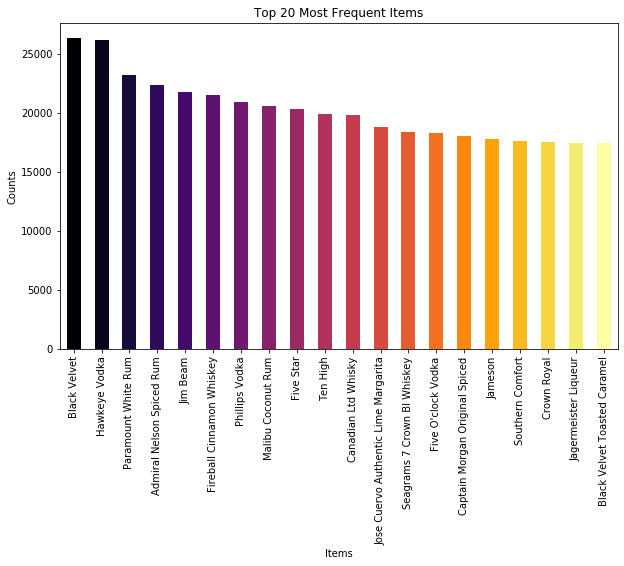

In [12]:
# Most frequent items bar plot
plt.rcParams['figure.figsize'] = (10,6)
color = plt.cm.inferno(np.linspace(0,1,20))
df1['item_name'].value_counts().head(20).plot.bar(color = color)
plt.title('Top 20 Most Frequent Items')
plt.ylabel('Counts')
plt.xlabel('Items')
plt.show()

In [51]:
basket_50 = (df_supermarket.groupby([pd.Grouper(key='date',freq='M'),'store_number','item_name'])['item_name'].\
             size().unstack().reset_index()\
         .fillna(0).set_index(['date','store_number']))

In [52]:
basket_50.head(2)

item_name                Absolut Swedish Vodka 80 Prf  \
date       store_number                                 
2012-01-31 2152                                   1.0   
           2500                                   2.0   

item_name                Admiral Nelson Spiced Rum  Bacardi Superior Rum  \
date       store_number                                                    
2012-01-31 2152                                1.0                   6.0   
           2500                                3.0                   2.0   

item_name                Barton Vodka  Black Velvet  \
date       store_number                               
2012-01-31 2152                   2.0           9.0   
           2500                   4.0           9.0   

item_name                Black Velvet Toasted Caramel  Canadian Club Whisky  \
date       store_number                                                       
2012-01-31 2152                                   0.0                   2.0   
           2500                                   0.0                   1.0   

item_name                Canadian Ltd Whisky  Captain Morgan Original Spiced  \
date       store_number                                                        
2012-01-31 2152                          4.0                             0.0   
           2500                          5.0                             4.0   

item_name                Captain Morgan Spiced Barrel  \
date       store_number                                 
2012-01-31 2152                                   0.0   
           2500                                   0.0   

item_name                Captain Morgan Spiced Rum  Crown Royal  \
date       store_number                                           
2012-01-31 2152                                5.0          0.0   
           2500                                8.0          1.0   

item_name                Crown Royal Canadian Whisky  Crown Royal Regal Apple  \
date       store_number                                                         
2012-01-31 2152                                  1.0                      0.0   
           2500                                  3.0                      0.0   

item_name                Dr. Mcgillicuddy's Cherry Schnapps  \
date       store_number                                       
2012-01-31 2152                                         2.0   
           2500                                         0.0   

item_name                Fireball Cinnamon Whiskey  \
date       store_number                              
2012-01-31 2152                                0.0   
           2500                                0.0   

item_name                Fireball Cinnamon Whiskey Mini Dispenser  \
date       store_number                                             
2012-01-31 2152                                               0.0   
           2500                                               0.0   

item_name                Five O'Clock Vodka  Five O'clock Vodka  Five Star  \
date       store_number                                                      
2012-01-31 2152                         0.0                 0.0        0.0   
           2500                         0.0                 4.0        3.0   

item_name                Grey Goose Vodka  Hawkeye Vodka  Hennessy VS  \
date       store_number                                                 
2012-01-31 2152                       1.0            8.0          0.0   
           2500                       1.0           10.0          0.0   

item_name                Jack Daniels Old #7 Black Lbl  Jagermeister Liqueur  \
date       store_number                                                        
2012-01-31 2152                                    2.0                   1.0   
           2500                                    6.0                   4.0   

item_name                Jameson  Jim Beam  \
date       store_number                      
2012-01-31 2152   

In [13]:
# # Create basket for creating the association rules
# basket_50 = (df1.groupby([pd.Grouper(key='date',freq='M'),'store_number','item_name'])['count'].\
#              sum().unstack().reset_index()\
#          .fillna(0).set_index(['date','store_number']))

In [53]:
# Converting count as binary values where 0 represents the absence of an item and 1 represents the presence. 
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket_50.applymap(encode_units)
basket_sets.head()

item_name                Absolut Swedish Vodka 80 Prf  \
date       store_number                                 
2012-01-31 2152                                     1   
           2500                                     1   
           2501                                     1   
           2502                                     1   
           2503                                     0   

item_name                Admiral Nelson Spiced Rum  Bacardi Superior Rum  \
date       store_number                                                    
2012-01-31 2152                                  1                     1   
           2500                                  1                     1   
           2501                                  1                     1   
           2502                                  1                     1   
           2503                                  0                     0   

item_name                Barton Vodka  Black Velvet  \
date       store_number                               
2012-01-31 2152                     1             1   
           2500                     1             1   
           2501                     1             1   
           2502                     1             1   
           2503                     0             1   

item_name                Black Velvet Toasted Caramel  Canadian Club Whisky  \
date       store_number                                                       
2012-01-31 2152                                     0                     1   
           2500                                     0                     1   
           2501                                     0                     1   
           2502                                     0                     1   
           2503                                     0                     0   

item_name                Canadian Ltd Whisky  Captain Morgan Original Spiced  \
date       store_number                                                        
2012-01-31 2152                            1                               0   
           2500                            1                               1   
           2501                            1                               1   
           2502                            1                               0   
           2503                            1                               1   

item_name                Captain Morgan Spiced Barrel  \
date       store_number                                 
2012-01-31 2152                                     0   
           2500                                     0   
           2501                                     0   
           2502                                     0   
           2503                                     0   

item_name                Captain Morgan Spiced Rum  Crown Royal  \
date       store_number                                           
2012-01-31 2152                                  1            0   
           2500                                  1            1   
           2501                                  1            1   
           2502                                  1            1   
           2503                                  1            1   

item_name                Crown Royal Canadian Whisky  Crown Royal Regal Apple  \
date       store_number                                                         
2012-01-31 2152                                    1                        0   
           2500                                    1                        0   
           2501                                    1                        0   
           2502                                    1                        0   
           2503                                    1                        0   

item_name                Dr. Mcgillicuddy's Cherry Schnapps  \
date       store_number                                       
20

In [54]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
#Generating frequent item sets
frequent_itemssets = apriori(basket_sets,min_support=0.5,use_colnames=True )

In [55]:
frequent_itemssets.head()

,support,itemsets
0,0.584945,(Absolut Swedish Vodka 80 Prf)
1,0.793518,(Admiral Nelson Spiced Rum)
2,0.579632,(Bacardi Superior Rum)
3,0.549876,(Barton Vodka)
4,0.932660,(Black Velvet)


In [56]:
# Creates association rules based on if-then frequency
my_rules = association_rules(frequent_itemssets,metric='lift')

In [57]:
my_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Black Velvet),(Absolut Swedish Vodka 80 Prf),0.932660,0.584945,0.562097,0.602681,1.030321,0.016542,1.044640
1,(Absolut Swedish Vodka 80 Prf),(Black Velvet),0.584945,0.932660,0.562097,0.960940,1.030321,0.016542,1.724001
2,(Five O'clock Vodka),(Absolut Swedish Vodka 80 Prf),0.647821,0.584945,0.516684,0.797572,1.363499,0.137744,2.050385
3,(Absolut Swedish Vodka 80 Prf),(Five O'clock Vodka),0.584945,0.647821,0.516684,0.883304,1.363499,0.137744,3.017916
4,(Absolut Swedish Vodka 80 Prf),(Hawkeye Vodka),0.584945,0.926957,0.562735,0.962030,1.037836,0.020516,1.923695


In [58]:
# Print out first 10 association rules
my_rules[(my_rules['confidence'] >= .9) & (my_rules['support'] >= 0.5)].head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Absolut Swedish Vodka 80 Prf),(Black Velvet),0.584945,0.932660,0.562097,0.960940,1.030321,0.016542,1.724001
4,(Absolut Swedish Vodka 80 Prf),(Hawkeye Vodka),0.584945,0.926957,0.562735,0.962030,1.037836,0.020516,1.923695
9,(Absolut Swedish Vodka 80 Prf),(Seagrams 7 Crown Bl Whiskey),0.584945,0.650655,0.534786,0.914249,1.405121,0.154188,4.073961
11,(Admiral Nelson Spiced Rum),(Black Velvet),0.793518,0.932660,0.754198,0.950449,1.019073,0.014115,1.358988
30,(Admiral Nelson Spiced Rum),(Hawkeye Vodka),0.793518,0.926957,0.754587,0.950940,1.025872,0.019031,1.488838
58,(Bacardi Superior Rum),(Black Velvet),0.579632,0.932660,0.558874,0.964187,1.033804,0.018274,1.880341
62,(Bacardi Superior Rum),(Hawkeye Vodka),0.579632,0.926957,0.559192,0.964738,1.040757,0.021899,2.071404
66,(Bacardi Superior Rum),(Seagrams 7 Crown Bl Whiskey),0.579632,0.650655,0.532235,0.918230,1.411239,0.155095,4.272292
69,(Barton Vodka),(Black Velvet),0.549876,0.932660,0.538363,0.979063,1.049753,0.025516,3.216352
70,(Barton Vodka),(Hawkeye Vodka),0.549876,0.926957,0.532767,0.968885,1.045232,0.023055,2.347504


In [59]:
frequent_itemssets.sort_values(by='support', ascending=False).head(20)


,support,itemsets
4,0.932660,(Black Velvet)
14,0.926957,(Hawkeye Vodka)
80,0.876691,"(Black Velvet, Hawkeye Vodka)"
25,0.823911,(Paramount White Rum)
1,0.793518,(Admiral Nelson Spiced Rum)
163,0.784555,"(Paramount White Rum, Hawkeye Vodka)"
89,0.784024,"(Paramount White Rum, Black Velvet)"
18,0.772618,(Jim Beam)
11,0.763479,(Fireball Cinnamon Whiskey)
50,0.754587,"(Admiral Nelson Spiced Rum, Hawkeye Vodka)"
